### Class 4

Last session we covered a lot of ground:

    - Numpy
    - Power analysis
    - Pandas
        - Use of outside API (Eurostat) to get data

Today we'll cover:

    - Pandas:
        - A bit of econometrics (last bit I swear)
    - Webscraping:
        - Let's start

#### Statsmodels

So far, we've:

- Used numpy to manually do regressions.
    - Did some power analysis
- Learnt about the existence of pandas to store data.

Now we'll learn about the package to use for classical econometrics analysis.

In [1]:
!pip install statsmodels

To use the package, we'll first simulate an econometric model.

You're trying to value the effect of education on the wage, a very classical exercise in econometrics.

Let the setting be such that

- Some people have a good network (i.e Social Capital) that increases both the likelihood of doing university and to get a good job.
- Social Capital is not measurable. Let's see how it biases our results

Kickstart the simulation by drawing the social capital of individuals

In [3]:
import pandas as pd
import numpy as np
# First let's generate a fake dataset with the variables that we have
dataset = pd.DataFrame(np.random.uniform(low = -1, high = 1, size = 1000), columns = ['Social Capital'])
# Look at the first 5
dataset.head(10)

,Social Capital
0,-0.622237
1,0.748082
2,0.633870
3,-0.388517
4,-0.907830
5,0.606746
6,0.707074
7,-0.279486
8,0.476827
9,-0.830952


Now draw a variable that gives you the propension to go to uni absent the social capital

In [4]:
# Now draw a variable that is a latent propension to go to uni
dataset['hid_uni'] = np.random.uniform(low = 0,  high = 1, size = 1000)
dataset.head()

,Social Capital,hid_uni
0,-0.622237,0.106809
1,0.748082,0.642341
2,0.633870,0.398323
3,-0.388517,0.598541
4,-0.907830,0.339244


Finally, create the variable that's 0 if an individual has not gone to uni, 1 otherwise

In [7]:
dataset['University'] = (dataset['hid_uni'] + dataset['Social Capital'] > 0.5) # Transform it to an integer value
dataset['University'] = dataset['University'].apply(lambda x: int(x))
dataset.head()

,Social Capital,hid_uni,University
0,-0.622237,0.106809,0
1,0.748082,0.642341,1
2,0.633870,0.398323,1
3,-0.388517,0.598541,0
4,-0.907830,0.339244,0


Why are we doing this? We're creating correlated variable, and we'll assume that social capital is unobservable to us, economists.

In [8]:
corr = dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,Social Capital,hid_uni,University
Social Capital,1.000000,-0.024667,0.791237
hid_uni,-0.024667,1.000000,0.266297
University,0.791237,0.266297,1.000000


Now let's imagine that for these individuals, we know their wages, and the wage process is given by

$wage_i = \alpha + \beta * uni_i + \gamma * social_i + \epsilon_i$

 - wage starts at a constant $\alpha$ and positively depends on both having gone to uni and having a lot of social capital

In [9]:
# Now let's create the wage variable
dataset['wage'] = 12000 + dataset['University']*2000 + dataset['Social Capital']*1000 + np.random.normal(loc = 0, scale = 50, size = 1000)
corr = dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,Social Capital,hid_uni,University,wage
Social Capital,1.000000,-0.024667,0.791237,0.912836
hid_uni,-0.024667,1.000000,0.266297,0.167871
University,0.791237,0.266297,1.000000,0.971116
wage,0.912836,0.167871,0.971116,1.000000


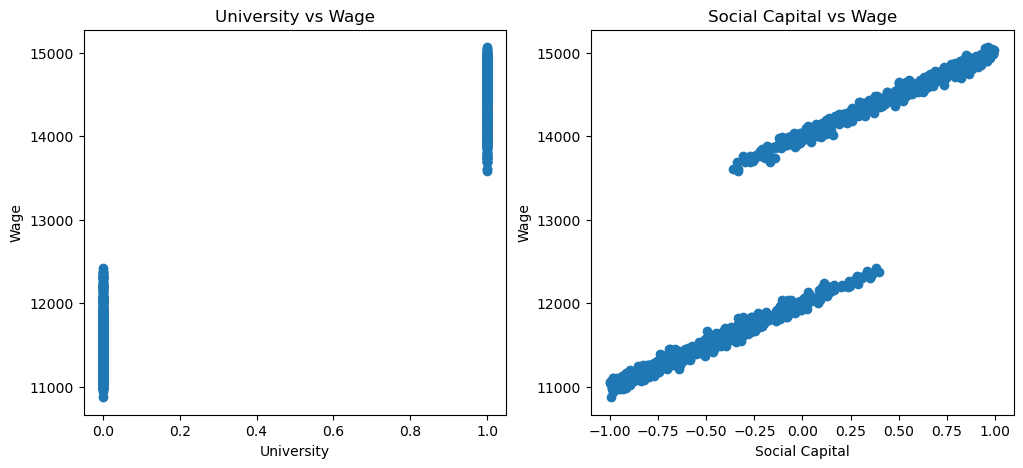

In [10]:
import matplotlib.pyplot as plt
# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns, and optionally set the figure size

# Plot for University vs Wage on the left subplot
ax[0].scatter(dataset['University'], dataset['wage'])
ax[0].set_title('University vs Wage')
ax[0].set_xlabel('University')
ax[0].set_ylabel('Wage')
ax[0].grid(False)
# Plot for Social Capital vs Wage on the right subplot
ax[1].scatter(dataset['Social Capital'], dataset['wage'])
ax[1].set_title('Social Capital vs Wage')
ax[1].set_xlabel('Social Capital')
ax[1].set_ylabel('Wage')
ax[1].grid(False)

# Display the plots
plt.show()

### Statsmodels

Let's start with regression on python

In [ ]:
!pip install statsmodels

In [12]:
import statsmodels.api as sm

# Add a constant
dataset['constant'] = 1

reg1 = sm.OLS(endog=dataset['wage'], exog=dataset[['constant', 'University']], missing='drop')
print(type(reg1))

<class 'statsmodels.regression.linear_model.OLS'>


With this package, you create a model object, and on this model you can implement various commands.

The most interesting command for us is often going to be `fit` - perform the regression

In [13]:
reg1 = reg1.fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 1.653e+04
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        08:25:18   Log-Likelihood:                -7301.9
No. Observations:                1000   AIC:                         1.461e+04
Df Residuals:                     998   BIC:                         1.462e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant    1.154e+04     15.938    724.282      0.0

We are overestimating the effect of university. The error we're making is called an `omitted variable bias`. In general there can be three categories of errors:

- Omitted variable bias
- Double Causality
- Measurement errors

In the case of an `omitted variable bias`, the bias on the coefficient estimated depends on the sign of the correlation between variables included and variables omitted

In [14]:
corr = dataset.drop(columns = 'constant').corr()
corr.style.background_gradient(cmap='coolwarm')

,Social Capital,hid_uni,University,wage
Social Capital,1.000000,-0.024667,0.791237,0.912836
hid_uni,-0.024667,1.000000,0.266297,0.167871
University,0.791237,0.266297,1.000000,0.971116
wage,0.912836,0.167871,0.971116,1.000000


Social capital is both positively correlated with university and wages: the bias overestimate the impact of university

There are two ways to go about this problem:

- Find a proxy for Social Capital and put it in the model.
- Find an instrument that pushes people into university and does not impact wage through any other channel

Let's do the proxy route. Imagine we can have a measure of Social Capital.

- Let's say we have a variable about social class, that tells us the following:
    - Social capital < -0.5 : 0
    - Social capital < 0: 1
    - Social capital > 0: 2
- Or imagine we can measure social capital, but imprecisely

In [15]:
dataset['class'] = dataset['Social Capital'].apply(lambda x: 0 if x < -0.5 else (1 if x <0 else 2))
dataset['wealth'] = dataset['Social Capital'] + np.random.normal(loc = 0, scale = 0.3, size = 1000)

corr = dataset[['Social Capital', 'class', 'wealth']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Social Capital,class,wealth
Social Capital,1.000000,0.913380,0.890579
class,0.913380,1.000000,0.816451
wealth,0.890579,0.816451,1.000000


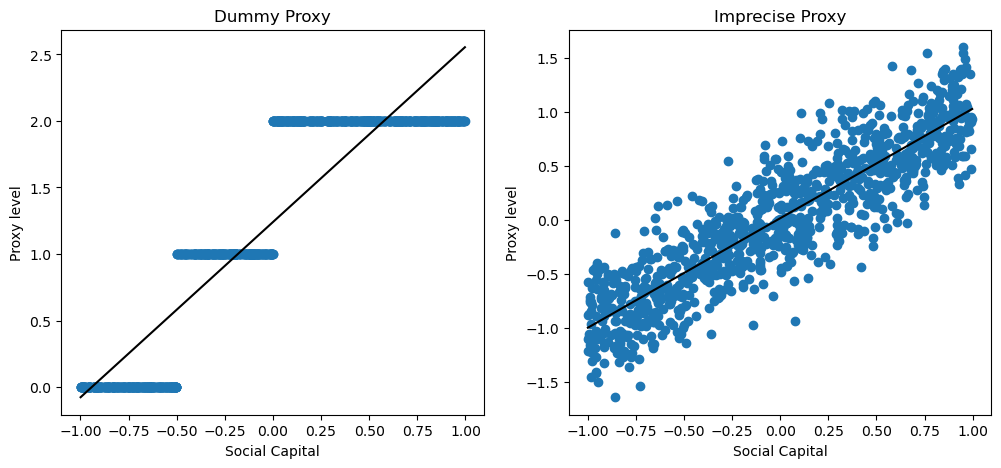

In [17]:
X = dataset['Social Capital']
y1 = dataset['class']
y2 = dataset['wealth']

# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns, and optionally set the figure size

# Plot for University vs Wage on the left subplot
ax[0].scatter(dataset['Social Capital'], dataset['class'])
ax[0].set_title('Dummy Proxy')
ax[0].set_xlabel('Social Capital')
ax[0].set_ylabel('Proxy level')
ax[0].plot(np.unique(X),
         np.poly1d(np.polyfit(X, y1, 1))(np.unique(X)),
         color='black')
ax[0].grid(False)

# Plot for Social Capital vs Wage on the right subplot
ax[1].scatter(dataset['Social Capital'], dataset['wealth'])
ax[1].set_title('Imprecise Proxy')
ax[1].set_xlabel('Social Capital')
ax[1].set_ylabel('Proxy level')
ax[1].plot(np.unique(X),
         np.poly1d(np.polyfit(X, y2, 1))(np.unique(X)),
         color='black')
ax[1].grid(False)

# Display the plots
plt.show()

Now we can perform a bunch of regressions:

    - One regression including our proxy number 1 - the dummy one
    - One regression including our proxy number 2 - the noisy one
    - One regression assuming we can actually observe social capital

In [19]:
reg2 = sm.OLS(endog=dataset['wage'], exog=dataset[['constant', 'University', 'class']], missing='drop').fit()
reg3 = sm.OLS(endog=dataset['wage'], exog=dataset[['constant', 'University', 'wealth']], missing='drop').fit()
truth = sm.OLS(endog=dataset['wage'], exog=dataset[['constant', 'University', 'Social Capital']], missing='drop').fit()

Looking at these results, we want to compare them with the previous ones. Hence we use another part of the library of statsmodels.

In [20]:
# Import the packages for regression visualisation
from statsmodels.iolib.summary2 import summary_col

info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[truth, reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            info_dict = info_dict,
                            model_names=['Truth',
                                         'Base Model',
                                         'Dummy Proxy',
                                         'Imprecise Proxy'])
print(results_table)


                    Truth     Base Model Dummy Proxy Imprecise Proxy
--------------------------------------------------------------------
constant         12002.18*** 11543.41*** 11229.64*** 11806.98***    
                 (3.06)      (15.94)     (12.51)     (12.44)        
University       2001.92***  2921.42***  2283.97***  2376.92***     
                 (5.24)      (22.72)     (21.07)     (20.61)        
Social Capital   1001.51***                                         
                 (4.52)                                             
class                                    509.25***                  
                                         (12.59)                    
wealth                                               584.89***      
                                                     (15.59)        
R-squared        1.00        0.94        0.98        0.98           
R-squared Adj.   1.00        0.94        0.98        0.98           
No. observations 1000        1000

It might work well, but in some cases it will be next to impossible to measure that unobservable, or indeed even to know what it is.

So in this case you find an exogenous source of variation in your variable of interest.

Assume the state gives a grant randomly to a random 15% of individuals to go to university. And that receiving this grant increases the probability to go to university.

In [22]:
# First let's generate a fake dataset with the variables that we have
dataset = pd.DataFrame(np.random.uniform(low = -1, high = 1, size = 1000), columns = ['Social Capital'])

dataset['Grant'] = np.random.uniform(low = 0, high = 1, size = 1000) < 0.15
dataset['Grant'] = dataset['Grant'].apply(lambda x: int(x))


# Now draw a random integer and sum it with the social capital, if it's superior to 0.5 we not "university educated"
dataset['hid_uni'] = np.random.uniform(low = 0,  high = 1, size = 1000)

The rest of the data generating process is kind of the same, but now I say that one goes to uni if

`hid_uni` + `social capital` + `grant` > 0.5

What this does is data generating process is the same for all individuals as before. Except for who got the grant that goes to university for sure!

In [23]:
dataset['University'] = (dataset['hid_uni'] + dataset['Social Capital'] + dataset['Grant'] > 0.5)
dataset['University'] = dataset['University'].apply(lambda x: int(x))

corr = dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,Social Capital,Grant,hid_uni,University
Social Capital,1.000000,0.024487,-0.022823,0.705094
Grant,0.024487,1.000000,-0.002874,0.337472
hid_uni,-0.022823,-0.002874,1.000000,0.260819
University,0.705094,0.337472,0.260819,1.000000


And now I compute the wage as before

In [24]:
dataset['wage'] = 12000 + dataset['University']*2000 + dataset['Social Capital']*1000 + np.random.normal(loc = 0, scale = 50, size = 1000)
corr = dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,Social Capital,Grant,hid_uni,University,wage
Social Capital,1.000000,0.024487,-0.022823,0.705094,0.874273
Grant,0.024487,1.000000,-0.002874,0.337472,0.241888
hid_uni,-0.022823,-0.002874,1.000000,0.260819,0.167748
University,0.705094,0.337472,0.260819,1.000000,0.959798
wage,0.874273,0.241888,0.167748,0.959798,1.000000


We perform what is called an instrumental variable regressions, where we first predict the probability to go to university as a function of receiving the grant, so as to "purge" the effect of university from its correlation with social capital.

For this regression we first perform the first step of regression going to university on having the grant.

In [25]:
# Estimate the first stage
dataset['Constant'] = 1
first_stage = sm.OLS(endog=dataset['University'], exog=dataset[['Constant', 'Grant']]).fit()

results_table = summary_col(results=[first_stage],
                            float_format='%0.2f',
                            stars = True,
                            info_dict = info_dict,
                            model_names=['First Stage'])
print(results_table)


                 First Stage
----------------------------
Constant         0.46***    
                 (0.02)     
Grant            0.47***    
                 (0.04)     
R-squared        0.11       
R-squared Adj.   0.11       
R-squared        0.11       
No. observations 1000       
Standard errors in
parentheses.
* p<.1, ** p<.05, ***p<.01


In [28]:
# Now we need to take the prediction and put it in the main regression, input the regression in the pandas dataset
dataset['predicted_uni'] = first_stage.predict()
dataset.head()
corr = dataset.drop(columns = ['Constant']).corr()
corr.style.background_gradient(cmap='coolwarm')

,Social Capital,Grant,hid_uni,University,wage,predicted_uni
Social Capital,1.000000,0.024487,-0.022823,0.705094,0.874273,0.024487
Grant,0.024487,1.000000,-0.002874,0.337472,0.241888,1.000000
hid_uni,-0.022823,-0.002874,1.000000,0.260819,0.167748,-0.002874
University,0.705094,0.337472,0.260819,1.000000,0.959798,0.337472
wage,0.874273,0.241888,0.167748,0.959798,1.000000,0.241888
predicted_uni,0.024487,1.000000,-0.002874,0.337472,0.241888,1.000000


In [29]:
second_stage = sm.OLS(endog=dataset['wage'], exog=dataset[['Constant', 'predicted_uni']]).fit()


results_table = summary_col(results=[truth, reg1, second_stage, reg2, reg3], float_format='%0.2f',
                            stars = True, info_dict = info_dict, 
                            model_names=['Truth',
                                         'Naive',
                                         'Instrument',
                                         'Dummy Proxy',
                                         'Imprecise Proxy'])
print(results_table)


                    Truth       Naive     Instrument Dummy Proxy Imprecise Proxy
--------------------------------------------------------------------------------
constant         12002.18*** 11543.41***             11229.64*** 11806.98***    
                 (3.06)      (15.94)                 (12.51)     (12.44)        
University       2001.92***  2921.42***              2283.97***  2376.92***     
                 (5.24)      (22.72)                 (21.07)     (20.61)        
Social Capital   1001.51***                                                     
                 (4.52)                                                         
Constant                                 11921.90***                            
                                         (149.17)                               
predicted_uni                            2098.15***                             
                                         (266.42)                               
class                      

The way we did things above is not a correct way to use IV regressions because we're not correcting the standard deviation as we should - we should use a package that takes care of doing so for us.

- Use `linearmodels`, an extention of statsmodels

In [ ]:
!pip install linearmodels

In [30]:
from linearmodels.iv import IV2SLS

# Let's run our IV regression
iv = IV2SLS(dependent=dataset['wage'],
            exog=dataset['Constant'],
            endog=dataset['University'],
            instruments=dataset['Grant']).fit()


print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   wage   R-squared:                      0.8621
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8620
No. Observations:                1000   F-statistic:                    407.13
Date:                Thu, May 02 2024   P-value (F-stat)                0.0000
Time:                        09:08:47   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Constant    1.192e+04     57.758     206.41     0.0000   1.181e+04   1.204e+04
University     2098.1     103.98     20.177     0.00

### Exercise 11 - Which one is consistent?

Put in a function the five regressions we just performed. The function takes as input the number of individuals in the sample.

Increase progressively the sample and let me know which one of the regressors for university is consistent (i.e converges to the true parameter's value).

In [83]:
def create_sample(n = 200):
    
    # First let's generate a fake dataset with the variables that we have
    dataset = pd.DataFrame(np.random.uniform(low = -1, high =1, size = n), columns = ['Social Capital'])
    
    # Create our proxies for social capital
    dataset['soc_1'] = dataset['Social Capital'].apply(lambda x: 0 if x < -.2 else (1 if x <0.2 else 2))
    dataset['soc_2'] = dataset['Social Capital'] + np.random.normal(loc = 0, scale = 0.5, size = n)
    
    # Create our grant instrument
    dataset['Grant'] = np.random.uniform(low = 0, high = 1, size = n) < 0.15
    dataset['Grant'] = dataset['Grant'].apply(lambda x: int(x))
    
    dataset['hid_uni'] = np.random.uniform(low = 0,  high = 1, size = n)


    # Now draw a random integer and sum it with the social capital, if it's superior to 0.5 we not "university educated"
    dataset['University'] = dataset['Social Capital']  + dataset['hid_uni'] + dataset['Grant'] > 0.5
    dataset['University'] = dataset['University'].apply(lambda x: int(x))
    
    # Add the constant
    dataset['constant'] = 1

    # Compute the wages
    dataset['wage'] = 12000 + dataset['University']*2000 + dataset['Social Capital']*1000 + np.random.normal(loc = 0, scale = 50, size = n)

    return(dataset)
    
    

In [89]:
df_test = create_sample(3000)
df_test.shape

(3000, 8)

In [90]:
def perform_regressions(dataset):
    
    # That's the naive regression
    reg1 = sm.OLS(endog=dataset['wage'], exog=dataset[['constant', 'University']], missing='drop').fit()
    
    # Those are the proxy regressions
    reg2 = sm.OLS(endog=dataset['wage'], exog=dataset[['constant', 'University', 'soc_1']], missing='drop').fit()
    reg3 = sm.OLS(endog=dataset['wage'], exog=dataset[['constant', 'University', 'soc_2']], missing='drop').fit()
    
    # Now do the instrumental variable regression
    # First stage and prediction
    first_stage = sm.OLS(endog=dataset['University'], exog=dataset[['constant', 'Grant']]).fit()
    dataset['predicted_uni'] = first_stage.predict()
    
    # Perform the second stage
    second_stage = sm.OLS(endog=dataset['wage'], exog=dataset[['constant', 'predicted_uni']]).fit()
    
    # Measure the distance between point estimate and actual values for each of these settings
    list_results = [
        dataset.shape[0], # That's the number of sampled individuals
        reg1.params['University']-2000,
        reg2.params['University']-2000,
        reg3.params['University']-2000,
        second_stage.params['predicted_uni']-2000
    ]
    
    return(list_results)
    

In [91]:
sample_to_test = np.linspace(start = 200, stop = 10000, num = int((10000 - 200)/200 + 1))
sample_to_test

array([  200.,   400.,   600.,   800.,  1000.,  1200.,  1400.,  1600.,
        1800.,  2000.,  2200.,  2400.,  2600.,  2800.,  3000.,  3200.,
        3400.,  3600.,  3800.,  4000.,  4200.,  4400.,  4600.,  4800.,
        5000.,  5200.,  5400.,  5600.,  5800.,  6000.,  6200.,  6400.,
        6600.,  6800.,  7000.,  7200.,  7400.,  7600.,  7800.,  8000.,
        8200.,  8400.,  8600.,  8800.,  9000.,  9200.,  9400.,  9600.,
        9800., 10000.])

In [92]:
# Let's now do our loop at multiple sample size
sample_to_test = np.linspace(start = 200, stop = 10000, num = int((10000 - 200)/200 + 1))
record_results = list()
for sample_size in sample_to_test:
    
    # Do the experiment at least 10 times
    for ii in range(10):
        
        # Perform the regressions
        dataset = create_sample(n = int(sample_size))
        reg_results = perform_regressions(dataset)
        
        # Store them
        record_results.append(reg_results)
    

We want to put this into a pandas dataframe, and plot the results

In [94]:
dataset_exp = pd.DataFrame(record_results, columns = ['sample', 'naive', 'soc_1', 'soc_2', 'iv'])
print(dataset_exp)

     sample       naive       soc_1       soc_2          iv
0       200  951.182080  236.418200  631.907927  595.356806
1       200  807.520275  141.183883  475.977944 -228.817012
2       200  824.010328   99.551394  505.196466  -33.330880
3       200  798.264897   62.619387  415.393077 -257.474547
4       200  808.290203  172.263844  451.272024   37.433657
..      ...         ...         ...         ...         ...
495   10000  827.371544  124.736699  490.866323   -0.800521
496   10000  822.547164  128.010646  492.127619  -13.844631
497   10000  825.442292  139.256182  488.332253  -10.266698
498   10000  824.552667  124.945487  498.115155  -23.836744
499   10000  830.368024  118.013673  497.308371    3.149451

[500 rows x 5 columns]


Let's take the average for each experiment across the sample, to do so, start by melting the dataset

In [95]:
dataset_exp = dataset_exp.melt(id_vars = "sample", var_name = 'model', value_name = 'distance')
print(dataset_exp)

      sample  model    distance
0        200  naive  951.182080
1        200  naive  807.520275
2        200  naive  824.010328
3        200  naive  798.264897
4        200  naive  808.290203
...      ...    ...         ...
1995   10000     iv   -0.800521
1996   10000     iv  -13.844631
1997   10000     iv  -10.266698
1998   10000     iv  -23.836744
1999   10000     iv    3.149451

[2000 rows x 3 columns]


Let's take the average over sample size and experiment


In [96]:
# THis is our dataset that will be ready for plotting
dataset_exp = dataset_exp.groupby(['sample', 'model'])['distance'].mean().reset_index()
dataset_exp.head()

,sample,model,distance
0,200,iv,97.395506
1,200,naive,838.653571
2,200,soc_1,136.990700
3,200,soc_2,506.509736
4,400,iv,11.787897


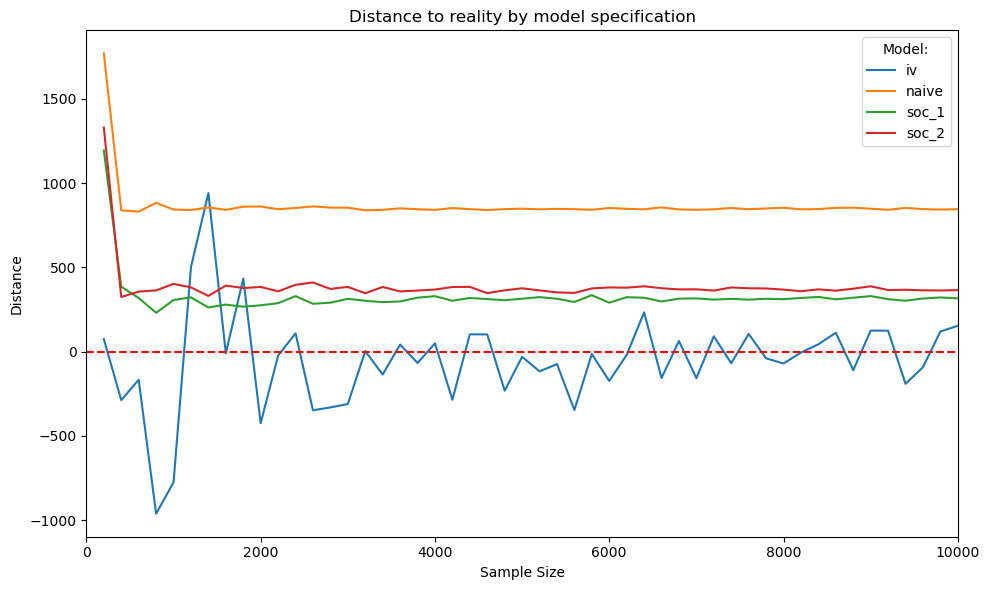

In [103]:
# Let's now plot it

plt.figure(figsize=(10, 6))  # Set the figure size as desired
for label, df in dataset_exp.groupby('model'):
    plt.plot(df['sample'], df['distance'], label=label)

# Set x-axis tick frequency: show every third tick
ax = plt.gca()  # Get the current axis

plt.xlim([0, 10000])
plt.title('Distance to reality by model specification')
plt.xlabel('Sample Size')
plt.ylabel('Distance')
plt.legend(title='Model:')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

### Webscraping

Let's start with webscraping. We all have quite of an idea of what webscraping is, but let's review it.

    - Write a code on python
    - the code "goes on a webpage"
    - it extracts information

Before we can use webscraping, it's important to know how a website is built.

    - HTML
    - CSS
    - Javascript
    - Server-side language (Node.js, Python, PHP)
    
For today, we'll focus on HTML and CSS.

Is it legal to webscrape?

    - No, publicly available data is not illegal to scrape.
    - If you log into a website, you might have signed some terms of service - often it forbids automatic data collection, but can they prove it was automatic?
    - The website lets you know what's its stance on webscraping: robots.txt
    
https://www.unibo.it/robots.txt

To most websites add, the "/robots.txt" at the end, all the information is there.

This means "for all user-agents, it's forbidden to scrape any part of the website"

``` 
User-agent: * 
Disallow: / 
``` 

This means "for all user-agents, nothing is forbidden"

```
User-agent: * 
Disallow: 
``` 

But again, it's hard to prove you used a scraper, and it's unlikely anyone will be mad at the non-commercial applications you'll do.

Some websites even use the robots.txt as a job offer:

https://www.booking.com/robots.txt

In [2]:
from IPython.display import display, HTML

# The URL of the website you want to embed
url = "https://www.booking.com/robots.txt"
# Define the HTML for the iframe
iframe = f'<iframe src="{url}" width="100%" height="500"></iframe>'
# Display the iframe in the notebook
display(HTML(iframe))

But before moving to real life examples, let's start with a simpler one.

https://quotes.toscrape.com/

In [97]:
from IPython.display import display, HTML
# The URL of the website you want to embed
url = "https://quotes.toscrape.com/"
# Define the HTML for the iframe
iframe = f'<iframe src="{url}" width="100%" height="800"></iframe>'
# Display the iframe in the notebook
display(HTML(iframe))

C:\Users\anato\anaconda3\envs\python-econ\Lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Let's say we build a pandas dataframe that contain all the quotes on this website, how would we proceed?

        - First, we need to import the HTML code on our machine

In [ ]:
!pip install requests

In [108]:
import requests

link = "https://quotes.toscrape.com/"
# Make a request to the website
website = requests.get(link)
print(website)

<Response [200]>


Response 200 is good, it means everything went well! - (why 200? I checked, actually arbitrary)

Now we can open up the responses and see what's inside

In [109]:
print(type(website.content))

<class 'bytes'>


A sequence of bytes is basically encoded strings - for example to make sure you can read any characters on your computer (accentuated letters, or even non-alphabetic characters)

In [110]:
# It looks a lot like one unique string though
print(website.content)

b'<!DOCTYPE html>\n<html lang="en">\n<head>\n\t<meta charset="UTF-8">\n\t<title>Quotes to Scrape</title>\n    <link rel="stylesheet" href="/static/bootstrap.min.css">\n    <link rel="stylesheet" href="/static/main.css">\n</head>\n<body>\n    <div class="container">\n        <div class="row header-box">\n            <div class="col-md-8">\n                <h1>\n                    <a href="/" style="text-decoration: none">Quotes to Scrape</a>\n                </h1>\n            </div>\n            <div class="col-md-4">\n                <p>\n                \n                    <a href="/login">Login</a>\n                \n                </p>\n            </div>\n        </div>\n    \n\n<div class="row">\n    <div class="col-md-8">\n\n    <div class="quote" itemscope itemtype="http://schema.org/CreativeWork">\n        <span class="text" itemprop="text">\xe2\x80\x9cThe world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.\xe2\x80\

To read html content, we `parse` it using:

    - BeautifulSoup

In [15]:
!pip install beautifulsoup4

In [111]:
from bs4 import BeautifulSoup

# Get the parsed content using the html parser
page_content = BeautifulSoup(website.content, "html.parser")

print(type(page_content))

<class 'bs4.BeautifulSoup'>


We get a new object! a beautiful soup object.

What does it look like?

In [112]:
print(page_content)

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<title>Quotes to Scrape</title>
<link href="/static/bootstrap.min.css" rel="stylesheet"/>
<link href="/static/main.css" rel="stylesheet"/>
</head>
<body>
<div class="container">
<div class="row header-box">
<div class="col-md-8">
<h1>
<a href="/" style="text-decoration: none">Quotes to Scrape</a>
</h1>
</div>
<div class="col-md-4">
<p>
<a href="/login">Login</a>
</p>
</div>
</div>
<div class="row">
<div class="col-md-8">
<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="

How is information organized?

In [98]:
cell_with_info = """
<div class="quote" itemscope itemtype="http://schema.org/CreativeWork">
    <span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
    <span>by <small class="author" itemprop="author">Albert Einstein</small>
    <a href="/author/Albert-Einstein">(about)</a>
    </span>
    <div class="tags">
        Tags:
        <meta class="keywords" itemprop="keywords" content="change,deep-thoughts,thinking,world" /    > 

        <a class="tag" href="/tag/change/page/1/">change</a>

        <a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>

        <a class="tag" href="/tag/thinking/page/1/">thinking</a>

        <a class="tag" href="/tag/world/page/1/">world</a>

    </div>
</div>
"""

What happens if I copy paste the chunk of code and asks python to interpret it as HTML?

In [99]:
from IPython.display import display, HTML
display(HTML(cell_with_info))

You get the skeleton of the website, but without the styling.

Just for the sake of exposition, let's add back the styling to the above. - We go and get it from their website

In [101]:
import requests
css_url = "http://quotes.toscrape.com/static/main.css"

css_file = requests.get(css_url)
print(css_file.text)

/* Custom page CSS */
body {
  font-family: sans-serif;
}

.container .text-muted {
  margin: 20px 0;
}

.tags-box {
  text-align: right;
}

.tags-box h2 {
  margin-top: 0px;
}

.tag-item {
  display: block;
  margin: 4px;
}

.quote {
  padding: 10px;
  margin-bottom: 30px;
  border: 1px solid #333333;
  border-radius: 5px;
  box-shadow: 2px 2px 3px #333333;
}

.quote small.author {
  font-weight: bold;
  color: #3677E8;
}

.quote span.text {
  display: block;
  margin-bottom: 5px;
  font-size: large;
  font-style: italic;
}

.quote .tags {
  margin-top: 10px;
}

.tag {
  padding: 2px 5px;
  border-radius: 5px;
  color: white;
  font-size: small;
  background-color: #7CA3E6;
}

a.tag:hover {
  text-decoration: none;
}

/* Sticky footer styles */
html {
  position: relative;
  min-height: 100%;
}

body {
  /* Margin bottom by footer height */
  margin-bottom: 60px;
}

.footer {
  position: absolute;
  bottom: 0;
  width: 100%;
  /* Set the fixed height of the footer here */
  height: 6e

Now let's put the two together and display it with the styling

In [102]:
full_content = f"<style>{css_file.text}</style>{cell_with_info}"
display(HTML(full_content))

I've recreated exactly their display:

    - HTML + CSS = Most of what you see online

To extract the information, we don't really use CSS styling

    - but we use the fact that the website was thought of using CSS.

The quote is in a `div` which has the attribute that its class is called `quote`

In [24]:
information = """
<div class="quote" itemscope itemtype="http://schema.org/CreativeWork">
    <span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
    <span>by <small class="author" itemprop="author">Albert Einstein</small>
    <a href="/author/Albert-Einstein">(about)</a>
    </span>
    <div class="tags">
        Tags:
        <meta class="keywords" itemprop="keywords" content="change,deep-thoughts,thinking,world" /    > 

        <a class="tag" href="/tag/change/page/1/">change</a>

        <a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>

        <a class="tag" href="/tag/thinking/page/1/">thinking</a>

        <a class="tag" href="/tag/world/page/1/">world</a>

    </div>
</div>
"""

We just have to select the first object that's a `div` and named `quote`

In [104]:
from bs4 import BeautifulSoup

# Rewrite the link
link = "https://quotes.toscrape.com/"

# Make a request to the website
website = requests.get(link)

# Get the parsed content using the html parser
page_content = BeautifulSoup(website.content, "html.parser")

# And now leverage on the power of beautifulsoup
albert_quote = page_content.find('div', attrs = {'class':'quote'})
print(albert_quote.text)


“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”
by Albert Einstein
(about)


            Tags:
            
change
deep-thoughts
thinking
world




We're actually not so happy about that, we took too much text

In [ ]:
information = """
<div class="quote" itemscope itemtype="http://schema.org/CreativeWork">
    <span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
    <span>by <small class="author" itemprop="author">Albert Einstein</small>
    <a href="/author/Albert-Einstein">(about)</a>
    </span>
    <div class="tags">
        Tags:
        <meta class="keywords" itemprop="keywords" content="change,deep-thoughts,thinking,world" /    > 

        <a class="tag" href="/tag/change/page/1/">change</a>

        <a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>

        <a class="tag" href="/tag/thinking/page/1/">thinking</a>

        <a class="tag" href="/tag/world/page/1/">world</a>

    </div>
</div>
"""

We can be more precise and access the `span` that of `class` `text`

In [107]:
albert_name = page_content.find('small', attrs = {'class':'author'})
print(albert_name.text)

Albert Einstein


In [106]:
# And now leverage on the power of beautifulsoup
albert_quote = page_content.find('span', attrs = {'itemprop':'text', 'class':'text'})
print(albert_quote.text)

“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”


In [ ]:
<div class="quote" itemscope itemtype="http://schema.org/CreativeWork">
    <span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
    <span>by <small class="author" itemprop="author">Albert Einstein</small>
    <a href="/author/Albert-Einstein">(about)</a>
    </span>
    <div class="tags">
        Tags:
        <meta class="keywords" itemprop="keywords" content="change,deep-thoughts,thinking,world" /    > 

        <a class="tag" href="/tag/change/page/1/">change</a>

        <a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>

        <a class="tag" href="/tag/thinking/page/1/">thinking</a>

        <a class="tag" href="/tag/world/page/1/">world</a>

    </div>
</div>

Let's access the author, in the `tag` `small` of `class` `author` 

In [29]:
# And now leverage on the power of beautifulsoup
quote_of = page_content.find('small', attrs = {'class':'author'})
print(quote_of.text)

Albert Einstein


In [ ]:
<div class="quote" itemscope itemtype="http://schema.org/CreativeWork">
    <span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
    <span>by <small class="author" itemprop="author">Albert Einstein</small>
    <a href="/author/Albert-Einstein">(about)</a>
    </span>
    <div class="tags">
        Tags:
        <meta class="keywords" itemprop="keywords" content="change,deep-thoughts,thinking,world" /    > 

        <a class="tag" href="/tag/change/page/1/">change</a>

        <a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>

        <a class="tag" href="/tag/thinking/page/1/">thinking</a>

        <a class="tag" href="/tag/world/page/1/">world</a>

    </div>
</div>

What if I want all the tags? Let's proceed in two stages, let's first access the `div` of `class` `tags` and then take all the `a` of class `tag`

In [112]:
# Take the div with all the tags
div_of_tags = page_content.find_all('a', attrs={'class':'tag'})
print(div_of_tags)

[<a class="tag" href="/tag/change/page/1/">change</a>, <a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>, <a class="tag" href="/tag/thinking/page/1/">thinking</a>, <a class="tag" href="/tag/world/page/1/">world</a>, <a class="tag" href="/tag/abilities/page/1/">abilities</a>, <a class="tag" href="/tag/choices/page/1/">choices</a>, <a class="tag" href="/tag/inspirational/page/1/">inspirational</a>, <a class="tag" href="/tag/life/page/1/">life</a>, <a class="tag" href="/tag/live/page/1/">live</a>, <a class="tag" href="/tag/miracle/page/1/">miracle</a>, <a class="tag" href="/tag/miracles/page/1/">miracles</a>, <a class="tag" href="/tag/aliteracy/page/1/">aliteracy</a>, <a class="tag" href="/tag/books/page/1/">books</a>, <a class="tag" href="/tag/classic/page/1/">classic</a>, <a class="tag" href="/tag/humor/page/1/">humor</a>, <a class="tag" href="/tag/be-yourself/page/1/">be-yourself</a>, <a class="tag" href="/tag/inspirational/page/1/">inspirational</a>, <a class="tag" hr

In [110]:
# Then access inside of it
tags = div_of_tags.find_all('a', attrs={'class':'tag'})
print(tags)

[<a class="tag" href="/tag/change/page/1/">change</a>, <a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>, <a class="tag" href="/tag/thinking/page/1/">thinking</a>, <a class="tag" href="/tag/world/page/1/">world</a>]


We use in this case a list comprehension:

    - a way to do a loop "inline", meaning in one line

In [111]:
# I can unpack that list and take the text inside of it
tags = [element.text for element in tags]
print(tags)

['change', 'deep-thoughts', 'thinking', 'world']


### Step back

We want to get all the quotes from this website. But each quote is organized in the same way!

    - We can use a `loop`

In [115]:
type(all_the_quotes)

bs4.element.ResultSet

In [113]:
# The first step of the loop is to get all the quotes into a list
all_the_quotes = page_content.find_all('div', attrs = {'class':'quote'})
print(len(all_the_quotes))

10


The first element is just our Einstein quote!

In [116]:
print(all_the_quotes[2])

<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="inspirational,life,live,miracle,miracles" itemprop="keywords"/>
<a class="tag" href="/tag/inspirational/page/1/">inspirational</a>
<a class="tag" href="/tag/life/page/1/">life</a>
<a class="tag" href="/tag/live/page/1/">live</a>
<a class="tag" href="/tag/miracle/page/1/">miracle</a>
<a class="tag" href="/tag/miracles/page/1/">miracles</a>
</div>
</div>


For each of the quote we want to get the same information:

    - the quote
    - the author of the quote
    - the tags

In [119]:
# Create an empty list where we store the information
quote_storage = list()
# Do a loop over each quote
for quote in all_the_quotes:
    # First take the content of the quote
    quote_text = quote.find('span', attrs={'class':'text'})
    
    # get the author
    quote_author = quote.find('small', attrs = {'class':'author'})
    
    # Store the information
    quote_storage.append([quote_text.text, quote_author.text])
    
dataset_of_quotes = pd.DataFrame(quote_storage, columns = ['quote', 'author'])
dataset_of_quotes.head(n = 3)

,quote,author
0,“The world as we have created it is a process ...,Albert Einstein
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling
2,“There are only two ways to live your life. On...,Albert Einstein


Now we can cast that information into a pandas dataframe

In [ ]:
import pandas as pd

df_quotes = pd.DataFrame(quote_storage, columns = ['quote', 'author', 'tags'])

### One loop isn't enough

We've taken 10 quotes, but we've only done 1 page. How do we take all of them?

    - You "press" Next each time until there's no more a next left
    - You increase by one the page number until the page you got has no error
    
We implement the latter together, you implement the former

In [126]:
base_domain_link = 'https://quotes.toscrape.com'
link = base_domain_link
storage_list = list()
while len(link) > 0:
    page_response = requests.get(link)
    page_content = BeautifulSoup(page_response.content, 'html.parser')

    all_the_quotes = page_content.find_all('div', attrs = {'class':'quote'})

    for quote in all_the_quotes:

        content_of_quote = quote.find('span', attrs={'class':'text'})
        author_of_quote = quote.find('small', attrs= {'class':'author'})
        storage_list.append([content_of_quote.text, author_of_quote.text])

    # get to the next button
    li_with_next = page_content.find('li', attrs={'class':'next'})
    if not li_with_next:
        link = ""
    else:
        next_page = li_with_next.find('a')
        link = base_domain_link + next_page['href']

In [130]:
dataset = pd.DataFrame(storage_list, columns = ['quote', 'author'])
print(dataset)

                                                quote              author
0   “The world as we have created it is a process ...     Albert Einstein
1   “It is our choices, Harry, that show what we t...        J.K. Rowling
2   “There are only two ways to live your life. On...     Albert Einstein
3   “The person, be it gentleman or lady, who has ...         Jane Austen
4   “Imperfection is beauty, madness is genius and...      Marilyn Monroe
..                                                ...                 ...
95  “You never really understand a person until yo...          Harper Lee
96  “You have to write the book that wants to be w...   Madeleine L'Engle
97  “Never tell the truth to people who are not wo...          Mark Twain
98        “A person's a person, no matter how small.”           Dr. Seuss
99  “... a mind needs books as a sword needs a whe...  George R.R. Martin

[100 rows x 2 columns]
